In [1]:
cpu_count = 100
import os
os.environ['XLA_FLAGS'] = f'--xla_force_host_platform_device_count={cpu_count}'
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random, jit, vmap

In [2]:
import dmeq

In [3]:
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
import arviz as az
import pandas as pd

In [4]:
n_chains = 10

In [5]:
key = random.PRNGKey(42)

In [6]:
def full_solution(params, eir, eta):
    p = dmeq.default_parameters()
    for k, v in params.items():
        p[k] = v
    p['EIR'] = eir
    p['eta'] = eta
    return dmeq.solve(p, dtype=jnp.float64)

In [7]:
population = 1_000_000
prev_N = 1_000

def prev_stats(params, eir, eta, impl=full_solution):
    solution = impl(params, eir, eta)
    inc_rates = solution[1] * solution[-1] * population
    return (
        jnp.array([
            solution[0, 3:10].sum() / solution[-1, 3:10].sum(), # Prev 2 - 10
            solution[0, 10:].sum() / solution[-1, 10:].sum(), # Prev 10+
        ]),
        jnp.array([
            inc_rates[:5].sum(), # Inc 0 - 5
            inc_rates[5:15].sum(), # Inc 5 - 15
            inc_rates[15:].sum() # Inc 15+
        ])
    )

In [8]:
prev_stats_multisite = vmap(prev_stats, in_axes=[None, 0, 0, None])

In [9]:
EIRs = jnp.array([0.05, 3.9, 15., 20., 100., 150., 418.])
key, key_i = random.split(key)
etas = 1. / random.uniform(key_i, shape=EIRs.shape, minval=20*365, maxval=40*365, dtype=jnp.float64)

In [10]:
def model(prev=None, inc=None, impl=lambda p, e, a: prev_stats_multisite(p, e, a, full_solution)):
    # Pre-erythrocytic immunity
    kb = numpyro.sample('kb', dist.LogNormal(0., .25))
    ub = numpyro.sample('ub', dist.LogNormal(0., .25))
    b0 = numpyro.sample('b0', dist.Beta(1., 1.))
    IB0 = numpyro.sample('IB0', dist.LeftTruncatedDistribution(dist.Normal(50., 10.), low=0.))
    
    # Clinical immunity
    kc = numpyro.sample('kc', dist.LogNormal(0., .25))
    uc = numpyro.sample('uc', dist.LogNormal(0., .25))
    phi0 = numpyro.sample('phi0', dist.Beta(5., 1.))
    phi1 = numpyro.sample('phi1', dist.Beta(1., 2.))
    IC0 = numpyro.sample('IC0', dist.LeftTruncatedDistribution(dist.Cauchy(100., 10.), low=0.))
    PM = numpyro.sample('PM', dist.Beta(1., 1.))
    dm = numpyro.sample('dm', dist.LeftTruncatedDistribution(dist.Cauchy(200., 10.), low=0.))
    
    # Detection immunity
    kd = numpyro.sample('kd', dist.LogNormal(0., .25))
    ud = numpyro.sample('ud', dist.LogNormal(0., .25))
    d1 = numpyro.sample('d1', dist.Beta(1., 2.))
    ID0 = numpyro.sample('ID0', dist.LeftTruncatedDistribution(dist.Cauchy(25., 1.), low=0.))
    fd0 = numpyro.sample('fd0', dist.Beta(1., 1.))
    gd = numpyro.sample('gd', dist.LogNormal(0., .25))
    ad0 = numpyro.sample('ad0', dist.TruncatedDistribution(
        dist.Cauchy(30. * 365., 365.),
        low=20. * 365.,
        high=40. * 365.
    ))
    
    du = numpyro.sample('du', dist.LeftTruncatedDistribution(dist.Cauchy(50., 1.), low=0.))
    
    # FOIM
    cd = numpyro.sample('cd', dist.Beta(1., 2.))
    cu = numpyro.sample('cu', dist.Beta(1., 5.))
    g_inf = numpyro.sample('g_inf', dist.Gamma(3., 1.))
    
    prev_stats, inc_stats = impl({
        'kb': kb,
        'ub': ub,
        'b0': b0,
        'IB0': IB0,
        'kc': kc,
        'uc': uc,
        'IC0': IC0,
        'phi0': phi0,
        'phi1': phi1,
        'PM': PM,
        'dm': dm,
        'kd': kd,
        'ud': ud,
        'd1': d1,
        'ID0': ID0,
        'fd0': fd0,
        'gd': gd,
        'ad0': ad0,
        'rU': 1. / du,
        'cD': cd,
        'cU': cu,
        'g_inf': g_inf
    }, EIRs, etas)
    numpyro.sample(
        'obs_prev',
        dist.Independent(
            dist.Binomial(total_count=prev_N, probs=prev_stats, validate_args=True),
            1
        ),
        obs=prev
    )
    numpyro.sample(
        'obs_inc',
        dist.Independent(
            dist.Poisson(rate=inc_stats),
            1
        ),
        obs=inc
    )

In [11]:
key, key_i = random.split(key)
true_values = Predictive(model, num_samples=1)(key_i)

In [12]:
true_values

{'IB0': Array([58.7365734], dtype=float64),
 'IC0': Array([103.92720686], dtype=float64),
 'ID0': Array([25.62619726], dtype=float64),
 'PM': Array([0.72981111], dtype=float64),
 'ad0': Array([10555.96766056], dtype=float64),
 'b0': Array([0.74543618], dtype=float64),
 'cd': Array([0.22820082], dtype=float64),
 'cu': Array([0.11498384], dtype=float64),
 'd1': Array([0.61861621], dtype=float64),
 'dm': Array([182.8618928], dtype=float64),
 'du': Array([61.98810811], dtype=float64),
 'fd0': Array([0.95786433], dtype=float64),
 'g_inf': Array([0.87178758], dtype=float64),
 'gd': Array([1.60818405], dtype=float64),
 'kb': Array([0.73792907], dtype=float64),
 'kc': Array([1.25727826], dtype=float64),
 'kd': Array([1.64091344], dtype=float64),
 'obs_inc': Array([[[  0,   0,   0],
         [ 10,  30,  26],
         [ 35,  59,  57],
         [ 34,  53,  84],
         [ 81, 116, 197],
         [146, 190, 192],
         [191, 251, 383]]], dtype=int64),
 'obs_prev': Array([[[  5,  10],
         [

In [13]:
obs_inc, obs_prev = (true_values['obs_inc'], true_values['obs_prev'])

In [14]:
print(pd.DataFrame(
    jnp.vstack([EIRs, etas, obs_prev[0].T, obs_inc[0].T]).T,
    columns=['EIR', 'eta', 'prev_2_10', 'prev_10+', 'inc_0_5', 'inc_5_15', 'inc_15+']
).to_latex(index=False))

\begin{tabular}{rrrrrrr}
\toprule
   EIR &      eta &  prev\_2\_10 &  prev\_10+ &  inc\_0\_5 &  inc\_5\_15 &  inc\_15+ \\
\midrule
  0.05 & 0.000118 &        5.0 &      10.0 &      0.0 &       0.0 &      0.0 \\
  3.90 & 0.000126 &      239.0 &     269.0 &     10.0 &      30.0 &     26.0 \\
 15.00 & 0.000089 &      400.0 &     402.0 &     35.0 &      59.0 &     57.0 \\
 20.00 & 0.000084 &      423.0 &     444.0 &     34.0 &      53.0 &     84.0 \\
100.00 & 0.000082 &      646.0 &     611.0 &     81.0 &     116.0 &    197.0 \\
150.00 & 0.000098 &      646.0 &     618.0 &    146.0 &     190.0 &    192.0 \\
418.00 & 0.000090 &      682.0 &     678.0 &    191.0 &     251.0 &    383.0 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_85112/3656896043.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(


In [15]:
def without_obs(params):
    return {k : v for k, v in params.items() if not k in {'obs_inc', 'obs_prev'}}

In [16]:
key, key_i = random.split(key)
prior = Predictive(model, num_samples=600)(key)

In [17]:
n_samples = 100
n_warmup = 100

mcmc = MCMC(
    NUTS(model),
    num_samples=n_samples,
    num_warmup=n_warmup,
    num_chains=n_chains,
    chain_method='vectorized'
)
mcmc.run(key, obs_prev, obs_inc)
mcmc.print_summary(prob=0.7)

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [1:25:35<00:00, 25.68s/it]



                mean       std    median     15.0%     85.0%     n_eff     r_hat
       IB0     52.32     10.08     52.12     41.66     62.92    808.38      1.00
       IC0    103.76     11.72    102.24     91.23    111.62    926.28      1.00
       ID0     24.47      2.83     24.81     23.09     26.63    321.80      1.03
        PM      0.51      0.29      0.51      0.32      1.00   1083.09      1.00
       ad0  10953.57    726.81  10946.75  10341.31  11437.97    525.25      1.01
        b0      0.73      0.05      0.72      0.67      0.77    529.91      1.01
        cd      0.32      0.23      0.28      0.00      0.44   1208.59      1.00
        cu      0.16      0.14      0.12      0.00      0.21   1129.80      1.00
        d1      0.58      0.03      0.58      0.56      0.62    469.08      1.01
        dm    189.67     35.90    196.73    182.72    219.43    146.14      1.05
        du     53.33     42.25     50.06     48.31     51.94    256.31      1.04
       fd0      0.79      0

In [18]:
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(
    model,
    posterior_samples
)(key, obs_prev, obs_inc)

In [19]:
from numpyro.diagnostics import summary
#d = pd.DataFrame(summary(mcmc.get_samples(group_by_chain=True), prob=0.7)).transpose()
d = pd.concat([
    pd.DataFrame(summary(mcmc.get_samples(group_by_chain=True), prob=0.7)).transpose()[['mean', 'std', 'n_eff', 'r_hat']],
    pd.DataFrame(summary(mcmc_surrogate.get_samples(group_by_chain=True), prob=0.7)).transpose()[['mean', 'std', 'n_eff', 'r_hat']],
    ks_tests
], axis=1, keys=['equilibrium solution', 'surrogate', 'KS'])
d['true_value'] = pd.Series(without_obs(true_values)).apply(lambda x: x[0]).astype(float)
print(d.to_latex(float_format="{:0.2f}".format))

NameError: name 'mcmc_surrogate' is not defined

In [20]:
pyro_data = az.from_numpyro(
    mcmc,
    prior=prior,
    posterior_predictive=posterior_predictive
)

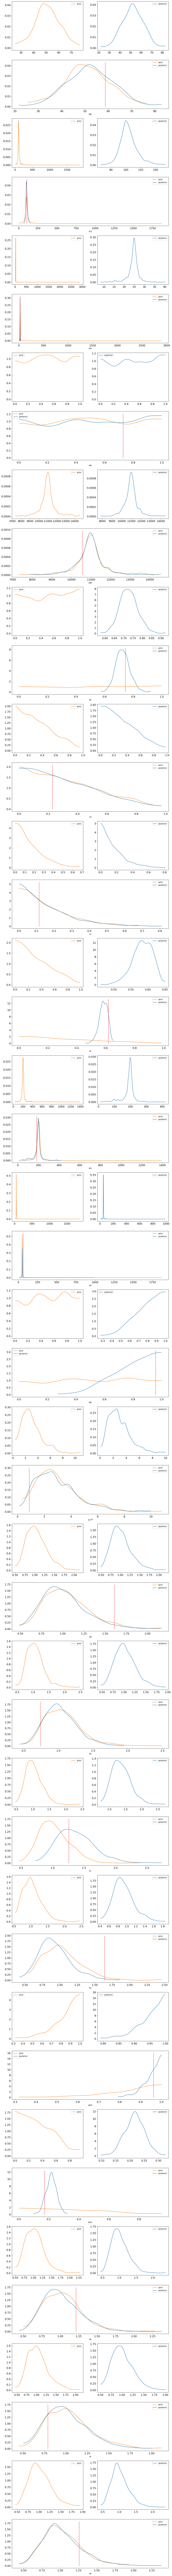

In [23]:
az.rcParams["plot.max_subplots"] = 200
keys = list(pyro_data.prior.data_vars.keys())
axs = az.plot_dist_comparison(pyro_data)
for i in range(axs.shape[0]):
    axs[i, 2].vlines(
        true_values[keys[i]][0],
        0,
        axs[i, 2].get_ylim()[1],
        color = 'red',
        linestyle = 'dashed'
    )
    
    for j in range(3):
        axs[i, j].legend()

In [ ]:
def get_curves(params, eirs, etas):
    return vmap(
        vmap(
            full_solution,
            in_axes=[
                {k: 0 for k in params.keys()},
                None,
                None
            ]
        ),
        in_axes=[None, 0, 0]
    )(params, eirs, etas)

In [ ]:
posterior_curves_surrogate = get_curves(posterior_samples_surrogate, EIRs, etas)
posterior_curves = get_curves(posterior_samples, EIRs, etas)
prior_curves = get_curves(prior, EIRs, etas)
true_curves = get_curves(without_obs(true_values), EIRs, etas)

In [ ]:
fig, axs = plt.subplots(3, len(EIRs), sharey=True, sharex=True)
imm_labels = ['b', 'c', 'd']
for i in range(len(EIRs)):
    axs[0, i].set_xlabel(
        f'EIR: {EIRs[i]}'
    )
    axs[0, i].xaxis.set_label_position('top')
    for imm in range(3):
        axs[imm, i].plot(posterior_curves[i, :, 2+imm, :].T, color='r', alpha=.01)
        axs[imm, i].plot(true_curves[i, 0, 2+imm, :])
        axs[imm, 0].set_ylabel(f'prob. {imm_labels[imm]}')
        
fig.tight_layout()
fig.text(0.5, 0, 'Age (years)', ha='center')
fig.text(0.5, 1, 'Posterior immunity probability function', ha='center')

In [ ]:
fig, axs = plt.subplots(2, len(EIRs), sharey='row', sharex=True)

prev_labels = ['pos_M', 'inc']
for i in range(len(EIRs)):
    for prev in range(2):
        axs[0, i].set_xlabel(
            f'EIR: {EIRs[i]}'
        )
        axs[0, i].xaxis.set_label_position('top')
        axs[prev, i].plot(posterior_curves[i, :, prev, :].T, color='r', alpha=.01)
        axs[prev, i].plot(true_curves[i, 0, prev, :])
        axs[prev, 0].set_ylabel(prev_labels[prev])
        #axs[prev, 0].set_yscale('log')
        
fig.tight_layout()
fig.text(0.5, 0, 'Age (years)', ha='center')
fig.text(0.5, 1, 'Posterior pos_M/inc function', ha='center')

In [ ]:
fig, axs = plt.subplots(3, len(EIRs), sharey=True, sharex=True)
imm_labels = ['b', 'c', 'd']
for i in range(len(EIRs)):
    axs[0, i].set_xlabel(
        f'EIR: {EIRs[i]}'
    )
    axs[0, i].xaxis.set_label_position('top')
    for imm in range(3):
        axs[imm, i].plot(prior_curves[i, :, 2+imm, :].T, color='r', alpha=.01)
        axs[imm, i].plot(true_curves[i, 0, 2+imm, :])
        axs[imm, 0].set_ylabel(f'prob. {imm_labels[imm]}')
        
fig.tight_layout()
fig.text(0.5, 0, 'Age (years)', ha='center')
fig.text(0.5, 1, 'Prior immunity probability function', ha='center')

In [ ]:
fig, axs = plt.subplots(2, len(EIRs), sharey='row', sharex=True)

prev_labels = ['pos_M', 'inc']
for i in range(len(EIRs)):
    for prev in range(2):
        axs[0, i].set_xlabel(
            f'EIR: {EIRs[i]}',
        )
        axs[0, i].xaxis.set_label_position('top')
        axs[prev, i].plot(prior_curves[i, :, prev, :].T, color='r', alpha=.01)
        axs[prev, i].plot(true_curves[i, 0, prev, :])
        axs[prev, 0].set_ylabel(prev_labels[prev])
        
fig.tight_layout()
fig.text(0.5, 0, 'Age (years)', ha='center')
fig.text(0.5, 1, 'Prior pos_M/inc function', ha='center')